In [56]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [57]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [58]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [59]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
#from matplotlib.patches import Rectangle
#from mpl_toolkits.basemap import Basemap
#from scipy.io import loadmat
import pickle
from cmocean import cm
import warnings
import netCDF4 as nc

from salishsea_tools import viz_tools

%matplotlib inline
warnings.simplefilter('ignore')



#### MEANS EXTRACTING CODE  - uses extract_bylayer_mean.py, which in subfolder bylayer_extract

    

#### LOAD PKLS OF ABOVE EXTRACTED QUANTITIES

In [60]:
#extract means for BR1-BR3, get fraser discharge
#var
BR1_var = pickle.load(open('./bylayer_extract/pkls/BR1_DIC_means_inletsIN.pkl' , 'rb')) 
BR2_var = pickle.load(open('./bylayer_extract/pkls/BR2_DIC_means_inletsIN.pkl' , 'rb')) 
BR3_var = pickle.load(open('./bylayer_extract/pkls/BR3_DIC_means_inletsIN.pkl' , 'rb')) 

PI1_var = pickle.load(open('./bylayer_extract/pkls/PI1_DIC_means_inletsIN.pkl' , 'rb')) 
PI2_var = pickle.load(open('./bylayer_extract/pkls/PI2_DIC_means_inletsIN.pkl' , 'rb')) 
PI3rr_var = pickle.load(open('./bylayer_extract/pkls/PI3rr_DIC_means_inletsIN.pkl' , 'rb')) 
PI4_var = pickle.load(open('./bylayer_extract/pkls/PI4_DIC_means_inletsIN.pkl' , 'rb')) 
PI4_var[PI4_var == 0] = np.nan
Fraser_discharge = pickle.load(open('./pkls/Fraser_2015_year_runoff_m3_s.pkl', 'rb'))  

mesh = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')
bath = nc.Dataset('/data/tjarniko/MEOPAR/grid/bathymetry_201702.nc')
depth = mesh['gdept_1d'][:]
days_in = np.arange(1,366,1)
#make a long 3-year dataset to be able to compare spinup progress for BR run


#### CALCULATE DEPTH-INTEGRATED BIOLOGY

In [61]:
flag ='./pkls/BR3_flagellates_means_inletsIN.pkl'
diat ='./pkls/BR3_diatoms_means_inletsIN.pkl'
cili ='./pkls/BR3_ciliates_means_inletsIN.pkl'
csd = '/KEY_MASBAL_LAT_TRANSPORT/pickles/cellsize_alg2.pkl'

flag_mas = pickle.load(open(flag, 'rb'))  
diat_mas = pickle.load(open(diat, 'rb'))
cili_mas = pickle.load(open(cili, 'rb'))

mmask = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')
depths = (mmask['e3t_1d'][:])

mask_broad = np.zeros([40,365])

for i in range(0,365):
    mask_broad[:,i] = depths


flag_mas_mm_m2 = np.nansum((mask_broad*flag_mas),axis = 0)
diat_mas_mm_m2 = np.nansum((mask_broad*diat_mas),axis = 0)
cili_mas_mm_m2 = np.nansum((mask_broad*cili_mas),axis = 0)

# nice plot - PI3rr

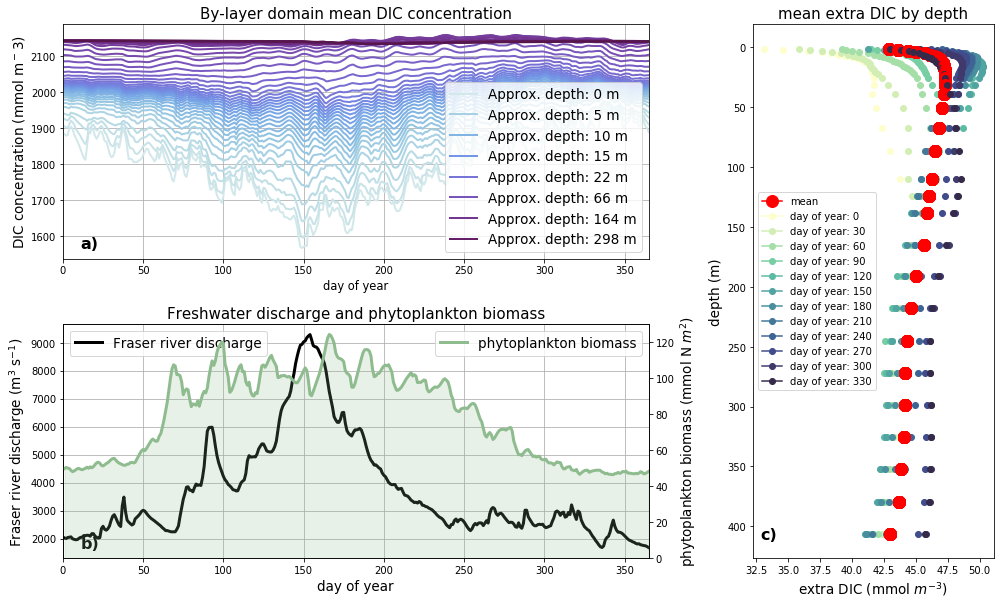

In [62]:
ts = 15 # title font
fs = 13.5 # all other font sizes
fact = 1
fig = plt.figure(figsize=(14*fact, 8.5*fact))
seg = 45
shift = 2
lw = 2
depth = mesh['e3t_0'][0,:,250,250]
ax1 = plt.subplot2grid((2,3), (0,0), colspan=2, rowspan=1)
tcm = cm.dense
for i in range(0,40):
    zdepth = np.sum(depth[0:i])
    if i%5 !=0: 
        ax1.plot(days_in,BR3_var[i,:],color = tcm(1.*(i+shift)/seg), linewidth = lw)
    if i%5 == 0:
        ax1.plot(days_in,BR3_var[i,:],color = tcm(1.*(i+shift)/seg),\
                label = 'Approx. depth: '+str(int(zdepth))+' m', linewidth = lw)
ax1.text(0.03, 0.03, 'a)', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='bottom')
ax1.legend(loc = 'best', fontsize = fs)
plt.xlim([0,365*1])
plt.grid()
ax1.set_xlabel('day of year', fontsize = fs-2)
ax1.set_ylabel('DIC concentration (mmol m$^-3$)', fontsize = fs)
ax1.set_title('By-layer domain mean DIC concentration', fontsize = ts)


ax2 = plt.subplot2grid((2,3), (1,0), colspan=2, rowspan=1)
ax2b =ax2.twinx()
ax2.plot(days_in,Fraser_discharge,'-k', linewidth = 3, label = 'Fraser river discharge')
ax2.grid()
#ax2b.plot(days_in,flag_mas_mm_m2,color = 'greenyellow',label ='flagellates')
#ax2b.plot(days_in,diat_mas_mm_m2,color = 'mediumspringgreen',label ='diatoms')
#ax2b.plot(days_in,cili_mas_mm_m2,color = 'forestgreen',label ='ciliates')
ax2b.plot(days_in, flag_mas_mm_m2+cili_mas_mm_m2+diat_mas_mm_m2,\
          color = 'darkseagreen', label = 'phytoplankton biomass', linewidth = 3)
ax2b.fill_between(days_in, np.zeros_like(flag_mas_mm_m2), (flag_mas_mm_m2+cili_mas_mm_m2+diat_mas_mm_m2), \
                 color = 'darkseagreen', alpha = 0.2 )

ax2b.legend(loc = 'best', fontsize = fs)
ax2.legend(loc = 'upper left', fontsize = fs)
ax2b.set_ylabel('phytoplankton biomass (mmol N $m^2$)', fontsize = fs)
ax2.set_xlabel('day of year', fontsize = fs)
ax2.set_ylabel('Fraser river discharge (m$^3$ s$^{-1}$)', fontsize = fs)
ax2.set_title('Freshwater discharge and phytoplankton biomass', fontsize = ts)
plt.xlim([0,365])
ax2b.set_ylim([0,130])
ax2.text(0.03, 0.03, 'b)', transform=ax2.transAxes, fontsize=16, fontweight='bold', va='bottom')


ax3 = plt.subplot2grid((2,3), (0,2), colspan=1, rowspan=2)
ax3.text(0.03, 0.03, 'c)', transform=ax3.transAxes, fontsize=16, fontweight='bold', va='bottom')
tcm = cm.deep
mesh = nc.Dataset('//data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')



for d in range(0,12):
    for i in range(0,40):
        zdepth = np.sum(depth[0:i+1]) 
        if ((i == 0) & (d ==0)):        
            ax3.plot((np.nanmean(BR3_var,axis =1)[i]-\
                      np.nanmean(PI3rr_var,axis=1)[i]),zdepth,\
                     marker = 'o', color = 'r', markersize = 12, label = 'mean')
        else:
            ax3.plot((np.nanmean(BR3_var,axis =1)[i]-\
                      np.nanmean(PI3rr_var,axis=1)[i]),zdepth,\
                     marker = 'o', color = 'r', markersize = 12)
        if i == 0:
            ax3.plot((BR3_var[i,d*30]-PI3rr_var[i,d*30]),zdepth,\
                    color = tcm(1.*d/12), marker = 'o', label = 'day of year: '+ str(d*30))
        else:
            ax3.plot((BR3_var[i,d*30]-PI3rr_var[i,d*30]),zdepth,\
                    color = tcm(1.*d/12), marker = 'o')

ax3.set_title('mean extra DIC by depth', fontsize = ts)
ax3.invert_yaxis()
ax3.legend(loc = 'best')
ax3.set_xlabel('extra DIC (mmol $m^{-3}$)', fontsize = fs)
ax3.set_ylabel('depth (m)', fontsize = fs)
fig.tight_layout()





## nice plot - PI4

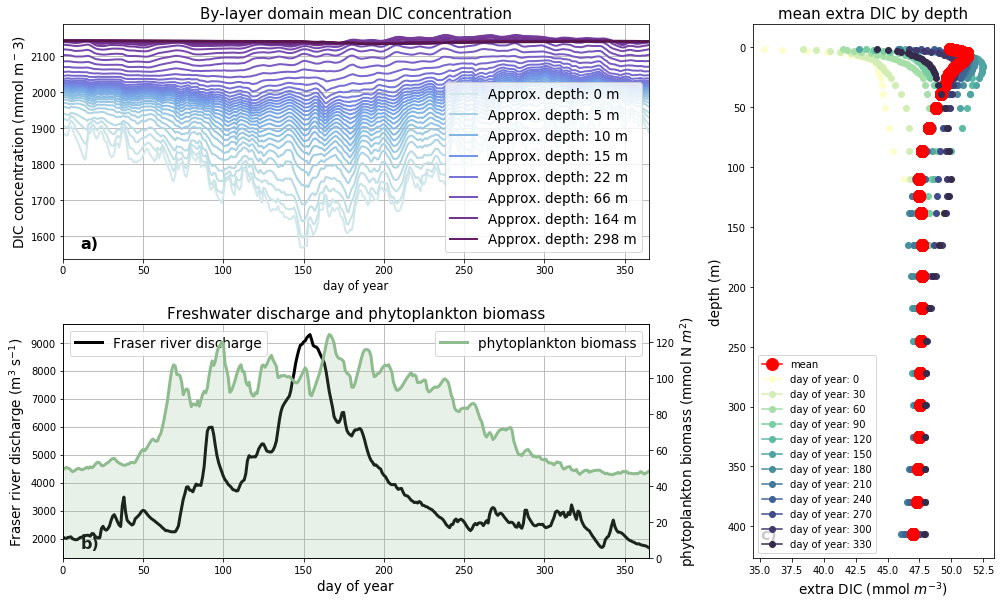

In [63]:
ts = 15 # title font
fs = 13.5 # all other font sizes
fact = 1
fig = plt.figure(figsize=(14*fact, 8.5*fact))
seg = 45
shift = 2
depth = mesh['e3t_0'][0,:,250,250]
ax1 = plt.subplot2grid((2,3), (0,0), colspan=2, rowspan=1)
tcm = cm.dense
for i in range(0,40):
    zdepth = np.sum(depth[0:i])
    if i%5 !=0: 
        ax1.plot(days_in,BR3_var[i,:],color = tcm(1.*(i+shift)/seg), linewidth = lw)
    if i%5 == 0:
        ax1.plot(days_in,BR3_var[i,:],color = tcm(1.*(i+shift)/seg),\
                label = 'Approx. depth: '+str(int(zdepth))+' m', linewidth = lw)
ax1.text(0.03, 0.03, 'a)', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='bottom')
ax1.legend(loc = 'best', fontsize = fs)
plt.xlim([0,365*1])
plt.grid()
ax1.set_xlabel('day of year', fontsize = fs-2)
ax1.set_ylabel('DIC concentration (mmol m$^-3$)', fontsize = fs)
ax1.set_title('By-layer domain mean DIC concentration', fontsize = ts)


ax2 = plt.subplot2grid((2,3), (1,0), colspan=2, rowspan=1)
ax2b =ax2.twinx()
ax2.plot(days_in,Fraser_discharge,'-k', linewidth = 3, label = 'Fraser river discharge')
ax2.grid()
#ax2b.plot(days_in,flag_mas_mm_m2,color = 'greenyellow',label ='flagellates')
#ax2b.plot(days_in,diat_mas_mm_m2,color = 'mediumspringgreen',label ='diatoms')
#ax2b.plot(days_in,cili_mas_mm_m2,color = 'forestgreen',label ='ciliates')
ax2b.plot(days_in, flag_mas_mm_m2+cili_mas_mm_m2+diat_mas_mm_m2,\
          color = 'darkseagreen', label = 'phytoplankton biomass', linewidth = 3)
ax2b.fill_between(days_in, np.zeros_like(flag_mas_mm_m2), (flag_mas_mm_m2+cili_mas_mm_m2+diat_mas_mm_m2), \
                 color = 'darkseagreen', alpha = 0.2 )

ax2b.legend(loc = 'best', fontsize = fs)
ax2.legend(loc = 'upper left', fontsize = fs)
ax2b.set_ylabel('phytoplankton biomass (mmol N $m^2$)', fontsize = fs)
ax2.set_xlabel('day of year', fontsize = fs)
ax2.set_ylabel('Fraser river discharge (m$^3$ s$^{-1}$)', fontsize = fs)
ax2.set_title('Freshwater discharge and phytoplankton biomass', fontsize = ts)
plt.xlim([0,365])
ax2b.set_ylim([0,130])
ax2.text(0.03, 0.03, 'b)', transform=ax2.transAxes, fontsize=16, fontweight='bold', va='bottom')


ax3 = plt.subplot2grid((2,3), (0,2), colspan=1, rowspan=2)
ax3.text(0.03, 0.03, 'c)', transform=ax3.transAxes, fontsize=16, fontweight='bold', va='bottom')
tcm = cm.deep
mesh = nc.Dataset('//data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')



for d in range(0,12):
    for i in range(0,40):
        zdepth = np.sum(depth[0:i+1]) 
        if ((i == 0) & (d ==0)):        
            ax3.plot((np.nanmean(BR3_var,axis =1)[i]-\
                      np.nanmean(PI4_var,axis=1)[i]),zdepth,\
                     marker = 'o', color = 'r', markersize = 12, label = 'mean')
        else:
            ax3.plot((np.nanmean(BR3_var,axis =1)[i]-\
                      np.nanmean(PI4_var,axis=1)[i]),zdepth,\
                     marker = 'o', color = 'r', markersize = 12)
        if i == 0:
            ax3.plot((BR3_var[i,d*30]-PI4_var[i,d*30]),zdepth,\
                    color = tcm(1.*d/12), marker = 'o', label = 'day of year: '+ str(d*30))
        else:
            ax3.plot((BR3_var[i,d*30]-PI4_var[i,d*30]),zdepth,\
                    color = tcm(1.*d/12), marker = 'o')

ax3.set_title('mean extra DIC by depth', fontsize = ts)
ax3.invert_yaxis()
ax3.legend(loc = 'best')
ax3.set_xlabel('extra DIC (mmol $m^{-3}$)', fontsize = fs)
ax3.set_ylabel('depth (m)', fontsize = fs)
fig.tight_layout()





In [64]:
print('calculation complete')

calculation complete


In [65]:
BR_var = np.zeros([40,365*3])
BR_var[:,0:365] = BR3_var- BR1_var
BR_var[:,365:2*365] = BR3_var - BR2_var

#
PI_var = np.zeros([40,365*3])
PI_var[:,0:365] = PI4_var- PI1_var
PI_var[:,365:2*365] = PI4_var - PI2_var
PI_var[:,365*2:3*365] = PI4_var - PI3rr_var

#### SPINUP METRICS - SUBTRACTING PREVIOUS RUNS (BR1,BR2 AND PI1-PI3rr) FROM MOST UP - TO - DATE RUN (BR3, PI4) - A PERFECTLY SPUN UP RUN WOULD HAVE NO DIFFERENCE. 

Text(0, 0.5, 'DIC difference')

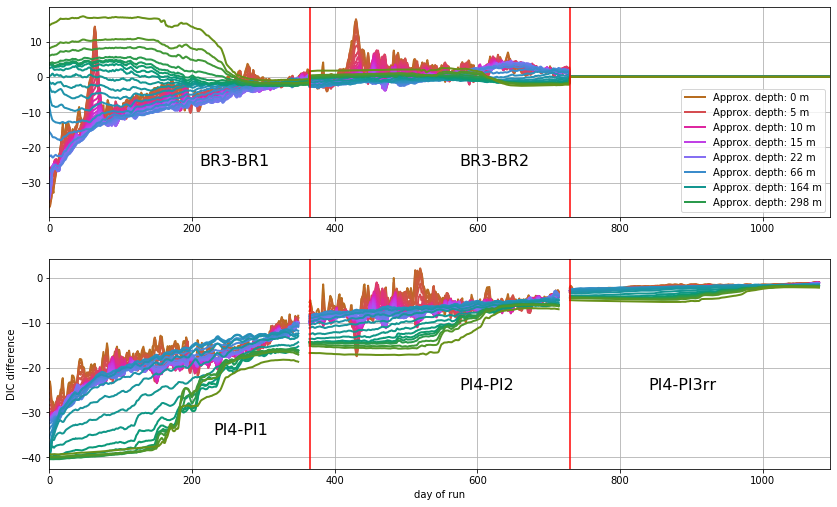

In [67]:

seg = 45
shift = 2
tcm = cm.phase
depth = mesh['e3t_0'][0,:,250,250]
days_in3 = np.arange(0,365*3,1)

fig = plt.figure(figsize=(14*fact, 8.5*fact))
ax1 = plt.subplot2grid((2,3), (0,0), colspan=3, rowspan=1)

for i in range(0,40):
    zdepth = np.sum(depth[0:i])
    if i%5 !=0: 
        ax1.plot(days_in3,BR_var[i,:],color = tcm(1.*(i+shift)/seg), linewidth = lw)
    if i%5 == 0:
        ax1.plot(days_in3,BR_var[i,:],color = tcm(1.*(i+shift)/seg),\
                label = 'Approx. depth: '+str(int(zdepth))+' m', linewidth = lw)
ax1.grid()
ax1.text(210,-25,'BR3-BR1', fontsize = 16)
ax1.text(210+365,-25,'BR3-BR2', fontsize = 16)
plt.axvline(x=365, color = 'r')
plt.axvline(x=365*2, color = 'r')

ax1.legend(loc = 'best')
ax1.set_xlim([0,1095])

ax2 = plt.subplot2grid((2,3), (1,0), colspan=3, rowspan=1)

for i in range(0,40):
    zdepth = np.sum(depth[0:i])
    if i%5 !=0: 
        ax2.plot(days_in3,PI_var[i,:],color = tcm(1.*(i+shift)/seg), linewidth = lw)
    if i%5 == 0:
        ax2.plot(days_in3,PI_var[i,:],color = tcm(1.*(i+shift)/seg),\
                label = 'Approx. depth: '+str(int(zdepth))+' m', linewidth = lw)

ax2.text(230,-35,'PI4-PI1', fontsize = 16)
ax2.text(210+365,-25,'PI4-PI2', fontsize = 16)
ax2.text(110+365*2,-25,'PI4-PI3rr', fontsize = 16)
ax2.grid()
ax2.set_xlabel('day of run')
plt.axvline(x=365, color = 'r')
plt.axvline(x=365*2, color = 'r')
ax2.set_xlim([0,1095])

ax2.set_xlabel('day of run')
ax2.set_ylabel('DIC difference')


Text(0.5, 1.0, 'By-layer domain mean DIC concentration - BR3 run - PI4 run ')

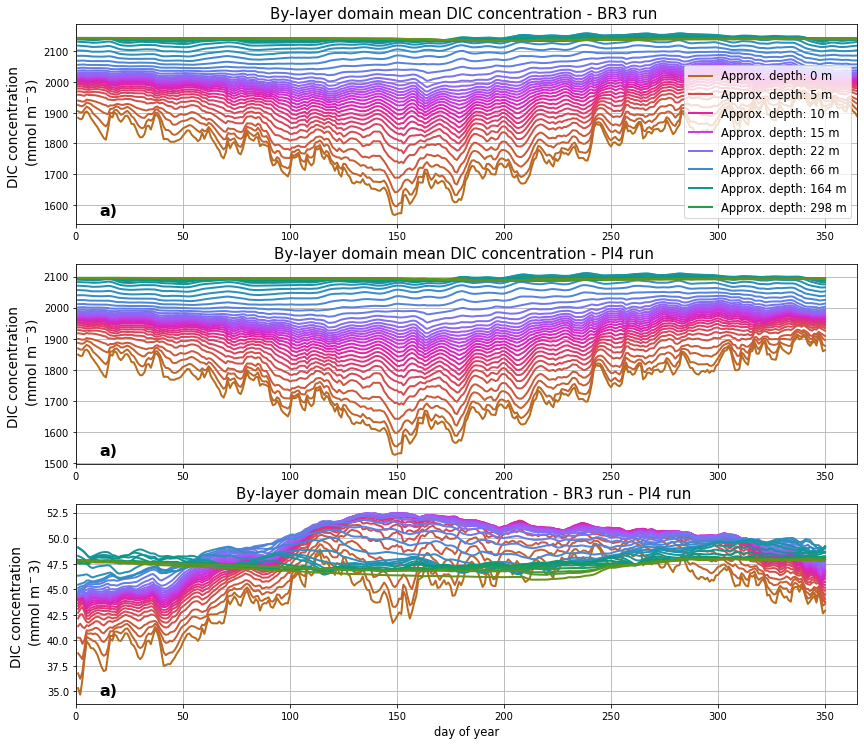

In [75]:

seg = 45
shift = 2
tcm = cm.phase
depth = mesh['e3t_0'][0,:,250,250]


fig = plt.figure(figsize=(14*fact, 12.5*fact))

ax1 = plt.subplot2grid((3,3), (0,0), colspan=3, rowspan=1)

tcm = cm.phase
for i in range(0,40):
    zdepth = np.sum(depth[0:i])
    if i%5 !=0: 
        ax1.plot(days_in,BR3_var[i,:],color = tcm(1.*(i+shift)/seg), linewidth = lw)
    if i%5 == 0:
        ax1.plot(days_in,BR3_var[i,:],color = tcm(1.*(i+shift)/seg),\
                label = 'Approx. depth: '+str(int(zdepth))+' m', linewidth = lw)
ax1.text(0.03, 0.03, 'a)', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='bottom')
ax1.legend(loc = 'best', fontsize = fs-2)
plt.xlim([0,365*1])
plt.grid()
#ax1.set_xlabel('day of year', fontsize = fs-2)
ax1.set_ylabel('DIC concentration \n (mmol m$^-3$)', fontsize = fs)
ax1.set_title('By-layer domain mean DIC concentration - BR3 run ', fontsize = ts)


ax2 = plt.subplot2grid((3,3), (1,0), colspan=3, rowspan=1)
for i in range(0,40):
    zdepth = np.sum(depth[0:i])
    if i%5 !=0: 
        ax2.plot(days_in,PI4_var[i,:],color = tcm(1.*(i+shift)/seg), linewidth = lw)
    if i%5 == 0:
        ax2.plot(days_in,PI4_var[i,:],color = tcm(1.*(i+shift)/seg),\
                label = 'Approx. depth: '+str(int(zdepth))+' m', linewidth = lw)
ax2.text(0.03, 0.03, 'a)', transform=ax2.transAxes, fontsize=16, fontweight='bold', va='bottom')
#ax2.legend(loc = 'best', fontsize = fs-2)
plt.xlim([0,365*1])
plt.grid()
#ax2.set_xlabel('day of year', fontsize = fs-2)
ax2.set_ylabel('DIC concentration \n (mmol m$^-3$)', fontsize = fs)
ax2.set_title('By-layer domain mean DIC concentration - PI4 run ', fontsize = ts)


ax3 = plt.subplot2grid((3,3), (2,0), colspan=3, rowspan=1)
for i in range(0,40):
    zdepth = np.sum(depth[0:i])
    if i%5 !=0: 
        ax3.plot(days_in,BR3_var[i,:]-PI4_var[i,:],color = tcm(1.*(i+shift)/seg), linewidth = lw)
    if i%5 == 0:
        ax3.plot(days_in,BR3_var[i,:]-PI4_var[i,:],color = tcm(1.*(i+shift)/seg),\
                label = 'Approx. depth: '+str(int(zdepth))+' m', linewidth = lw)
ax3.text(0.03, 0.03, 'a)', transform=ax3.transAxes, fontsize=16, fontweight='bold', va='bottom')
#ax3.legend(loc = 'best', fontsize = fs-2)
plt.xlim([0,365*1])
plt.grid()
ax3.set_xlabel('day of year', fontsize = fs-2)
ax3.set_ylabel('DIC concentration \n (mmol m$^-3$)', fontsize = fs)
ax3.set_title('By-layer domain mean DIC concentration - BR3 run - PI4 run ', fontsize = ts)